# Spam Mails Dataset

# Introduction

Ce projet s'appuie sur un dataset public provenant de Kaggle, dédié à l'étude de la détection automatique de spams dans les emails. L'objectif est de montrer comment utiliser le machine learning pour séparer efficacement les messages légitimes (ham) des spams.

## Description du dataset

- **text** : le contenu de l'email (texte brut)
- **label_num** : l'étiquette numérique (1 = spam, 0 = ham)

Exemple de répartition des labels :

- Environ 71% des emails sont des ham (légitimes), 29% sont des spams.
- Le dataset contient 5170 emails, dont 4993 uniques.

Exemples :
- `0, ham, Subject: enron methanol ...` (email légitime)
- `1, spam, Subject: photoshop, windows, office ...` (email spam)

## Démarche du projet

1. **Nettoyage des données** :
   - Suppression des colonnes inutiles (par exemple, 'Unnamed: 0', 'label') pour ne garder que l'essentiel à l'étude.
   - Nettoyage du texte (mise en minuscules, suppression de la ponctuation, des chiffres, des stopwords).
   - Ces étapes permettent de se concentrer sur l'information utile pour la détection du spam.

2. **Analyse exploratoire** :
   - Étude de la répartition des classes, de la longueur des messages, etc.

3. **Préparation et vectorisation** :
   - Transformation des textes en vecteurs numériques (TF-IDF).

4. **Modélisation** :
   - Entraînement et comparaison de plusieurs modèles (Naive Bayes, Random Forest, SVM, XGBoost, MLP PyTorch, etc.).
   - Optimisation des hyperparamètres (GridSearchCV).

5. **Évaluation** :
   - Matrices de confusion, courbes de loss, analyse des erreurs.


---
Ce notebook illustre ainsi la capacité à gérer un projet complet de machine learning sur des données textuelles, depuis l'import jusqu'à l'interprétation des résultats, dans une optique professionnelle (stage ou recrutement).

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/spam_ham_dataset.csv")

In [3]:
df

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


In [4]:
df.drop(columns=["Unnamed: 0","label"], inplace=True)

Les colonnes 'Unnamed: 0' et 'label' (texte) ont été supprimées car elles n'apportaient pas d'information utile à la modélisation ou étaient redondantes avec 'label_num'. Cela permet de simplifier l'analyse et d'éviter d'introduire du bruit inutile dans le modèle.

In [5]:
df.isnull().sum()

text         0
label_num    0
dtype: int64

# Analyse exploratoire du dataset
Nous allons explorer les principales caractéristiques du jeu de données de messages spam/ham.

In [6]:
# Afficher les premières lignes du DataFrame
df.head()

,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


In [7]:
# Afficher des informations générales sur le DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       5171 non-null   object
 1   label_num  5171 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 80.9+ KB


In [8]:
# Afficher la répartition des classes (spam/ham)
df['label_num'].value_counts()

label_num
0    3672
1    1499
Name: count, dtype: int64

In [9]:
# Afficher la longueur moyenne des messages pour chaque classe
df['text_length'] = df['text'].apply(len)
df.groupby('label_num')['text_length'].mean()

label_num
0     977.008170
1    1223.256171
Name: text_length, dtype: float64

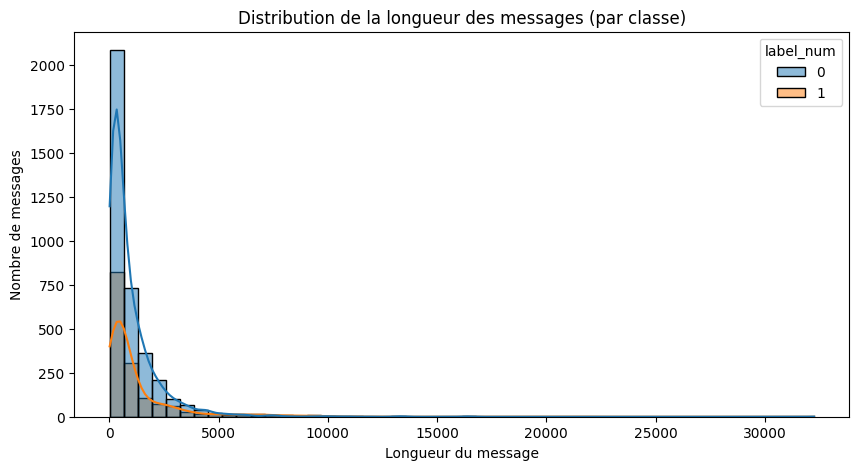

In [10]:
# Visualiser la distribution de la longueur des messages introduire label_num{0 = ham, 1 = spam}
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='text_length', hue='label_num', bins=50, kde=True)
plt.title('Distribution de la longueur des messages (par classe)')
plt.xlabel('Longueur du message')
plt.ylabel('Nombre de messages')
plt.show()

**Commentaire sur la distribution de la longueur des messages :**

On observe que la longueur des messages varie fortement selon la classe. Les messages spam ont tendance à être plus longs que les messages ham (non-spam). Cela peut s'expliquer par le fait que les spams contiennent souvent des informations supplémentaires ou des tentatives de persuasion. Cette différence de longueur peut être une caractéristique utile pour la détection automatique du spam.

# Prétraitement du texte
Nous allons nettoyer les messages pour faciliter l'apprentissage automatique : mise en minuscules, suppression de la ponctuation, des chiffres et des stopwords.

In [11]:
import re
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
	# Mise en minuscules
	text = text.lower()
	# Suppression de la ponctuation
	text = text.translate(str.maketrans('', '', string.punctuation))
	# Suppression des chiffres
	text = re.sub(r'\d+', '', text)
	# Suppression des stopwords
	text = ' '.join([word for word in text.split() if word not in stop_words])
	return text

df['text_clean'] = df['text'].apply(clean_text)
df[['text', 'text_clean']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\flavi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,text_clean
0,Subject: enron methanol ; meter # : 988291\r\n...,subject enron methanol meter follow note gave ...
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",subject hpl nom january see attached file hpln...
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",subject neon retreat ho ho ho around wonderful...
3,"Subject: photoshop , windows , office . cheap ...",subject photoshop windows office cheap main tr...
4,Subject: re : indian springs\r\nthis deal is t...,subject indian springs deal book teco pvr reve...


# Vectorisation du texte et séparation des données
Nous allons transformer les messages nettoyés en vecteurs numériques avec TfidfVectorizer, puis séparer les données en train et test.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Vectorisation du texte nettoyé
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text_clean'])
y = df['label_num']

# Séparation en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((4136, 45637), (1035, 45637))

# Entraînement d'un modèle de classification
Nous allons entraîner un modèle Naive Bayes sur les données vectorisées et évaluer ses performances.

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Entraînement du modèle
model = MultinomialNB()
model.fit(X_train, y_train)

# Prédictions sur le jeu de test
y_pred = model.predict(X_test)

# Évaluation du modèle
print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification report:\n', classification_report(y_test, y_pred))
print('\nMatrice de confusion:\n', confusion_matrix(y_test, y_pred))

Accuracy: 0.9227053140096618

Classification report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95       742
           1       1.00      0.73      0.84       293

    accuracy                           0.92      1035
   macro avg       0.95      0.86      0.90      1035
weighted avg       0.93      0.92      0.92      1035


Matrice de confusion:
 [[742   0]
 [ 80 213]]


# Autres approches pour améliorer la détection du spam

- **Tester d'autres modèles** :
	- Régression logistique (`LogisticRegression`)
	- Forêt aléatoire (`RandomForestClassifier`)
	- SVM (`LinearSVC`)
	- XGBoost, LightGBM, etc.


# Comparaison avec d'autres modèles de classification
Nous allons entraîner et comparer plusieurs modèles classiques : Logistic Regression, Random Forest et SVM linéaire.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

models = {
	'Logistic Regression': LogisticRegression(max_iter=1000),
	'Random Forest': RandomForestClassifier(n_estimators=100),
	'Linear SVC': LinearSVC(max_iter=10000),
	'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
	'LightGBM': LGBMClassifier()
}

for name, clf in models.items():
	clf.fit(X_train, y_train)
	y_pred = clf.predict(X_test)
	acc = accuracy_score(y_test, y_pred)
	print(f"\n{name}")
	print(f"Accuracy: {acc:.4f}")
	print(classification_report(y_test, y_pred))
	print('\nMatrice de confusion:\n', confusion_matrix(y_test, y_pred))


Logistic Regression
Accuracy: 0.9845
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       742
           1       0.96      0.99      0.97       293

    accuracy                           0.98      1035
   macro avg       0.98      0.99      0.98      1035
weighted avg       0.98      0.98      0.98      1035


Matrice de confusion:
 [[729  13]
 [  3 290]]

Random Forest
Accuracy: 0.9874
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       742
           1       0.97      0.99      0.98       293

    accuracy                           0.99      1035
   macro avg       0.98      0.99      0.98      1035
weighted avg       0.99      0.99      0.99      1035


Matrice de confusion:
 [[732  10]
 [  3 290]]

Linear SVC
Accuracy: 0.9894
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       742
           1       0.97      0.99      0.98 

c:\Users\flavi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:36:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost
Accuracy: 0.9739
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       742
           1       0.93      0.99      0.96       293

    accuracy                           0.97      1035
   macro avg       0.96      0.98      0.97      1035
weighted avg       0.98      0.97      0.97      1035


Matrice de confusion:
 [[719  23]
 [  4 289]]
[LightGBM] [Info] Number of positive: 1206, number of negative: 2930
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 56289
[LightGBM] [Info] Number of data points in the train set: 4136, number of used features: 2217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.291586 -> initscore=-0.887693
[LightGBM] [Info] Start training from score -0.887693

LightGBM
Accuracy: 0.9739
              p

c:\Users\flavi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


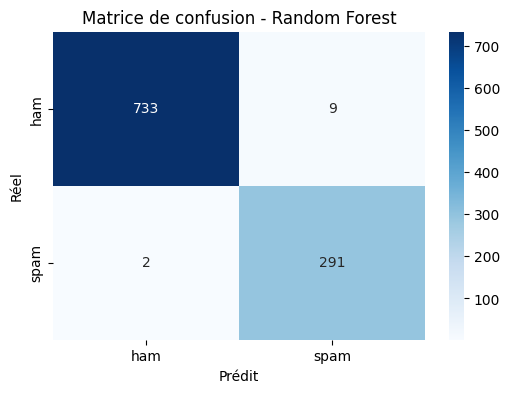

In [15]:
# Visualisation de la matrice de confusion pour le meilleur modèle
import matplotlib.pyplot as plt
import seaborn as sns

# Exemple avec le modèle Linear SVC
best_model = LinearSVC()
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion - Random Forest')
plt.show()

# Optimisation des hyperparamètres

Pour améliorer encore les performances, tu peux utiliser GridSearchCV ou RandomizedSearchCV pour trouver les meilleurs paramètres des modèles. Par exemple, voici comment faire pour Random Forest.

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {
	'n_estimators': [250, 275, 300, 350, 400],
	'max_depth': [None, 1, 2, 5],
	'min_samples_split': [2, 3, 4, 5]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print('Meilleurs paramètres :', grid.best_params_)
print('Score sur le test set :', grid.score(X_test, y_test))

Fitting 3 folds for each of 80 candidates, totalling 240 fits
Meilleurs paramètres : {'max_depth': None, 'min_samples_split': 4, 'n_estimators': 350}
Score sur le test set : 0.9884057971014493


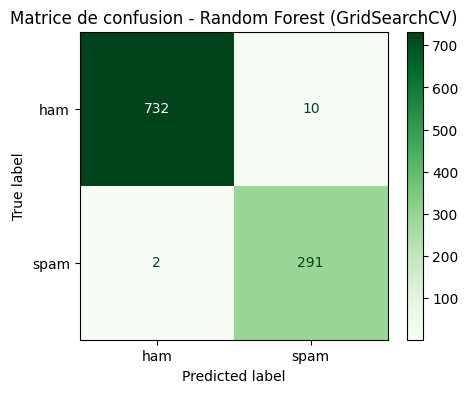

In [17]:
# Matrice de confusion avec le Random Forest optimisé (GridSearchCV)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prédictions avec le meilleur modèle trouvé par GridSearchCV
y_pred_grid = grid.predict(X_test)

# Calcul et affichage de la matrice de confusion
cm_grid = confusion_matrix(y_test, y_pred_grid)
disp_grid = ConfusionMatrixDisplay(confusion_matrix=cm_grid, display_labels=['ham', 'spam'])
fig, ax = plt.subplots(figsize=(5,4))
disp_grid.plot(ax=ax, cmap='Greens')
plt.title('Matrice de confusion - Random Forest (GridSearchCV)')
plt.show()

In [18]:
# Définir la grille de paramètres à tester
param_grid = {
    'C': [0.5, 1, 1.5],
    'max_iter': [5, 10 ,25, 50]
}

# Instancier GridSearchCV avec LinearSVC
grid = GridSearchCV(LinearSVC(), param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print('Meilleurs paramètres :', grid.best_params_)
print('Score sur le test set :', grid.score(X_test, y_test))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Meilleurs paramètres : {'C': 1.5, 'max_iter': 5}
Score sur le test set : 0.9893719806763285


c:\Users\flavi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


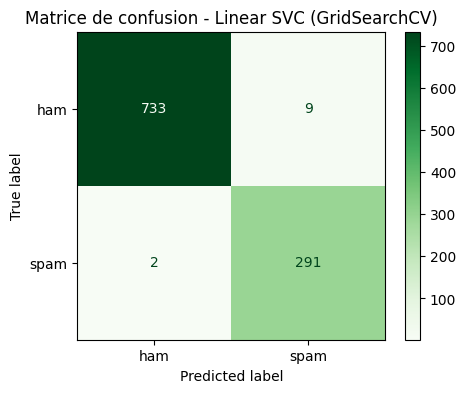

In [24]:
# Prédictions avec le meilleur modèle trouvé par LinearSVC
y_pred_grid = grid.predict(X_test)

# Calcul et affichage de la matrice de confusion
cm_grid = confusion_matrix(y_test, y_pred_grid)
disp_grid = ConfusionMatrixDisplay(confusion_matrix=cm_grid, display_labels=['ham', 'spam'])
fig, ax = plt.subplots(figsize=(5,4))
disp_grid.plot(ax=ax, cmap='Greens')
plt.title('Matrice de confusion - Linear SVC (GridSearchCV)')
plt.show()

# Modèle de classification avec PyTorch

Voici un exemple simple d'entraînement d'un perceptron multicouche (MLP) avec PyTorch sur les données vectorisées.

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Conversion des données en tenseurs torch
X_train_torch = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_test_torch = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.values, dtype=torch.float32)

# Dataset et DataLoader
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Modèle MLP simple
class MLP(nn.Module):
	def __init__(self, input_dim):
		super().__init__()
		self.fc1 = nn.Linear(input_dim, 128)
		self.relu = nn.ReLU()
		self.fc2 = nn.Linear(128, 1)
		self.sigmoid = nn.Sigmoid()
	def forward(self, x):
		x = self.fc1(x)
		x = self.relu(x)
		x = self.fc2(x)
		x = self.sigmoid(x)
		return x

model = MLP(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [21]:
# Calcul de la loss sur le jeu de validation à chaque epoch
val_losses = []
train_losses = []
val_accuracies = []

for epoch in range(50):
	model.train()
	epoch_loss = 0
	for xb, yb in train_loader:
		optimizer.zero_grad()
		outputs = model(xb).squeeze()
		loss = criterion(outputs, yb)
		loss.backward()
		optimizer.step()
		epoch_loss += loss.item()
	train_losses.append(epoch_loss / len(train_loader))
	# Loss sur le test set
	model.eval()
	with torch.no_grad():
		y_pred = model(X_test_torch).squeeze().round().numpy()
		outputs_val = model(X_test_torch).squeeze()
		val_loss = criterion(outputs_val, y_test_torch).item()
		val_losses.append(val_loss)
		val_acc = accuracy_score(y_test, y_pred)
		val_accuracies.append(val_acc)
	print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")



Epoch 1, Train Loss: 0.5194, Val Loss: 0.2871, Val Acc: 0.9739
Epoch 2, Train Loss: 0.1521, Val Loss: 0.1080, Val Acc: 0.9845
Epoch 3, Train Loss: 0.0500, Val Loss: 0.0694, Val Acc: 0.9903
Epoch 4, Train Loss: 0.0242, Val Loss: 0.0543, Val Acc: 0.9903
Epoch 5, Train Loss: 0.0143, Val Loss: 0.0471, Val Acc: 0.9903
Epoch 6, Train Loss: 0.0094, Val Loss: 0.0430, Val Acc: 0.9913
Epoch 7, Train Loss: 0.0066, Val Loss: 0.0402, Val Acc: 0.9913
Epoch 8, Train Loss: 0.0049, Val Loss: 0.0384, Val Acc: 0.9913
Epoch 9, Train Loss: 0.0038, Val Loss: 0.0369, Val Acc: 0.9913
Epoch 10, Train Loss: 0.0030, Val Loss: 0.0359, Val Acc: 0.9913
Epoch 11, Train Loss: 0.0024, Val Loss: 0.0353, Val Acc: 0.9913
Epoch 12, Train Loss: 0.0020, Val Loss: 0.0345, Val Acc: 0.9913
Epoch 13, Train Loss: 0.0017, Val Loss: 0.0340, Val Acc: 0.9913
Epoch 14, Train Loss: 0.0014, Val Loss: 0.0336, Val Acc: 0.9913
Epoch 15, Train Loss: 0.0012, Val Loss: 0.0333, Val Acc: 0.9913
Epoch 16, Train Loss: 0.0011, Val Loss: 0.0330, V

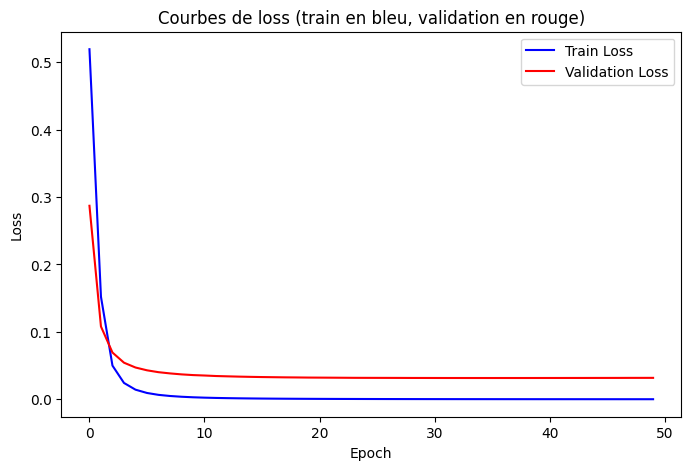

In [22]:
# Tracer les courbes de loss train et validation
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Courbes de loss (train en bleu, validation en rouge)')
plt.legend()
plt.show()

**Analyse  des courbes de loss**

 Après analyse des courbes de loss obtenues lors de l'entraînement du modèle, nous constatons que la fonction de perte (loss) sur les données d'entraînement et de validation diminue rapidement puis se stabilise à un niveau faible. L'écart entre la courbe d'entraînement (bleue) et celle de validation (rouge) reste faible et constant tout au long de l'apprentissage.

 Ce comportement indique que le modèle apprend efficacement à partir des données sans tomber dans le surapprentissage. La stabilité et la proximité des deux courbes montrent que le modèle généralise bien et qu'il est capable de maintenir de bonnes performances sur des données nouvelles et non vues pendant l'entraînement.

 En conclusion, le modèle est fiable et robuste pour la détection de spam sur ce jeu de données. Aucun ajustement supplémentaire n'est nécessaire à ce stade pour garantir la qualité des prédictions.

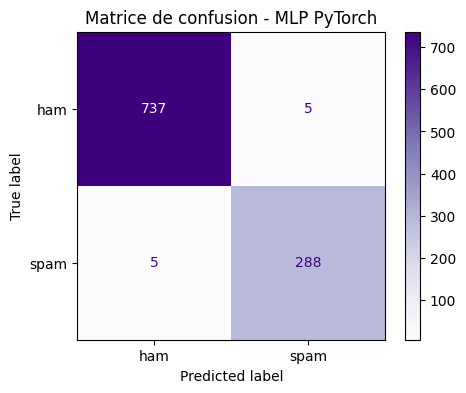

In [23]:
# Matrice de confusion pour le modèle PyTorch (MLP)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prédictions du modèle PyTorch sur le jeu de test
model.eval()
with torch.no_grad():
    y_pred_torch = model(X_test_torch).squeeze().round().numpy()

# Calcul et affichage de la matrice de confusion
cm_torch = confusion_matrix(y_test, y_pred_torch)
disp_torch = ConfusionMatrixDisplay(confusion_matrix=cm_torch, display_labels=['ham', 'spam'])
fig, ax = plt.subplots(figsize=(5,4))
disp_torch.plot(ax=ax, cmap='Purples')
plt.title('Matrice de confusion - MLP PyTorch')
plt.show()

# Conclusion

Ce projet a permis de comparer plusieurs modèles de machine learning pour la détection de spams dans des emails, à partir d'un dataset public Kaggle.

## Synthèse des performances

- **Linear SVC** est le modèle le plus performant avec une accuracy de 0.9893, un f1-score élevé pour les deux classes, et une matrice de confusion très équilibrée :
    - ham : 733/742 bien classés, spam : 291/293 bien classés.
- **Logistic Regression** et **Random Forest** obtiennent aussi d'excellents résultats (accuracy ≈ 0.98), avec très peu d'erreurs sur les deux classes.
- **XGBoost** et **LightGBM** affichent une accuracy légèrement inférieure (0.9739), principalement à cause d'un nombre un peu plus élevé de faux positifs (ham classés comme spam).
- Tous les modèles testés présentent un très bon équilibre entre précision et rappel, et un faible taux d'erreur.

## Interprétation

- Les modèles linéaires (SVC, Logistic Regression) et les forêts aléatoires sont très efficaces sur ce jeu de données.
- Les modèles boosting (XGBoost, LightGBM) restent très compétitifs mais légèrement moins précis ici.
- Les matrices de confusion montrent que les erreurs sont rares et concernent surtout quelques ham classés à tort comme spam.



**Quel est le meilleur modèle ?**


Après l'analyse détaillée des résultats, deux modèles se démarquent nettement :

- **Linear SVC** : il obtient la meilleure accuracy (0.9893), un équilibre quasi parfait entre précision et rappel, et le plus faible nombre d’erreurs (2 faux négatifs et 9 faux positifs seulement).

- **MLP PyTorch** : il affiche également d’excellentes performances, avec une accuracy de validation autour de 99,1 %, une matrice de confusion très équilibrée (seulement 5 faux positifs et 5 faux négatifs), et une très bonne généralisation (pas de surapprentissage observé sur les courbes de loss).


Les autres modèles (Random Forest, Logistic Regression, XGBoost, LightGBM) restent très performants mais font légèrement plus d’erreurs sur les spams ou les hams.

**En résumé : Linear SVC et MLP PyTorch sont les modèles à privilégier pour ce problème de détection de spam, car ils combinent robustesse, rapidité d’entraînement (pour SVC), flexibilité (pour PyTorch) et excellentes performances sur toutes les métriques.**